# Parallel Computing
K-Means clustering with cuda

Compiled with

```bash
nvcc -o out main.cu -std=c++11 --optimize 3 -arch=sm_70
```

## About
This notebook will be used to present the data from successive runs on a single core of the phaedra machine vs that same but leveraging the GPU.

The GPU (a Tesla V100 `-arch=sm_70`) was used in the cluster assignment step which accounts for the `knh/t` computation rate in millions of interactions per second.
    - `t` time
    - `k` clusters
    - `n` number of points
    - `h` iterations until convergence

### Other Considerations

The number of threads was chosen to be 512 after empirically testing on the problem sets and finding it made little difference at those numbers but was not hurting performance.

The code can be edited to enable the the `dump` option (not added to command line yet was pressed for time) for visualization of the clustering steps.

The `gpu` flag can also be individually assigned at runtime to determine if the GPU or CPU should be used for the cluster assignment step.

The code was initially written so that each point would have a cluster parameter. This was later changed to save memory and instead a cluster array was used. This has the massive benefit of only needing to copy the points to the GPU once on startup.

I initially struggled when getting the cluster assignment kernel working because of the differences array that was used locally to a given thread. After much debugging a settled on using `__shared__` memory for the differences array. This quickly was not feasible as for any high number of thread counts the local register space would be exhausted. I settled on creating space in the global memory for the entire differences array.

One of the biggest problems with my implementation currently is that the performance absolutely tanked at 1,000,000 points and `k > 200`. I am unsure if this was because other students were testing or if I have a memory leak causes performance to plumet. I initally wrote the program to be run 1 time and then quit so I suspect when I ported it over for benching and testing I missed a memory free causing my inability to test large values for n.

## Takeaways

I was totally overwhelmed at first by the strange syntax in the CUDA language. Luckily once you read over the cuda slides from nvidia 3-4 times things start making sense. I feel rather confident in my ability to utilize a GPU now for easily parallelize tasks. Of course I still love the Rust language too much to switch to C for Cuda. They are working on Cuda libraries for Rust so someday I'll be able to enjoy that.

I feel like GPU programming is this topic that really isnt ever touched on and seemingly has a really higher barrier to entry. It was nice to be able to actually learn it in short enough time to get something done and see performance gains. I wish I had done this sooner. If you can wrap your kernel calls behind proxy functions (like syscalls) then you don't even have to consider that you are using a GPU which is very nice.

In [246]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [247]:
base = 2
choice = 0
df = pd.read_csv(r"B:\code\633\final-py\data.csv")
df.head()

,n,k,num_iterations,mflops,gpu,num_threads
0,1000,50,12,39.648449,1,512
1,1000,50,16,130.144791,0,512
2,1000,100,10,78.783585,1,512
3,1000,100,19,125.148201,0,512
4,1000,150,10,119.265327,1,512


#### mflops vs K
for gpu 1 = true and gpu = 0 false (so cpu)

<AxesSubplot:xlabel='k', ylabel='mflops'>

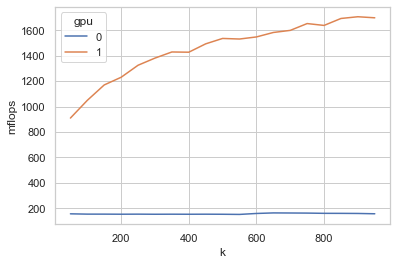

In [248]:
data = df.groupby(['k', 'gpu'])['mflops'].mean().to_frame()
sns.lineplot(data=data, x='k', y='mflops', hue='gpu', markers=True)

#### Showing mflops vs N
for gpu 1 = true and gpu = 0 false (so cpu)
  - log scale in the x direction

[None]

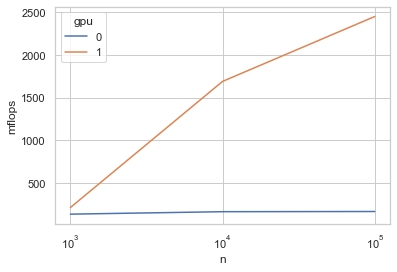

In [255]:
data = df.groupby(['n', 'gpu'])['mflops'].mean().to_frame()
ax = sns.lineplot(data=data, x='n', y='mflops', hue='gpu')
ax.set(xscale='log')

#### Showing mflops vs k for gpus
This plot shows the overhead of the gpu memory loading. More interactions per seconds because we are spending more time in the gpu.

<AxesSubplot:xlabel='k', ylabel='mflops'>

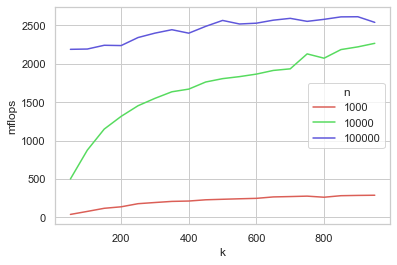

In [283]:
data = df[df['gpu'] == 1].groupby(['n', 'k'])['mflops'].mean().to_frame()
# ax = sns.lineplot(data=data, x='k', y='mflops', hue='gpu')
# ax.set(xscale='log')
sns.lineplot(data=data, x='k', y='mflops', hue='n',palette=sns.color_palette('hls', 3))

### Main Cuda Section

```cpp
__global__ void assign_clusters_kernel(Point *points,
                                       int *clusters,
                                       Point *centers,
                                       float *dists,
                                       unsigned int n,
                                       unsigned int k) {
//  extern __shared__ float dists[];
  unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
  if (i >= n) return;

//  int dists_idx = 0;
  int dists_idx = i * k;
  for (int cluster_idx = 0; cluster_idx < k; ++cluster_idx) {
    float x = points[i].x - centers[cluster_idx].x;
    float y = points[i].y - centers[cluster_idx].y;
    dists[dists_idx + cluster_idx] = sqrt(pow(x, 2) + pow(y, 2));
  }
  // https://riptutorial.com/cplusplus/example/11151/find-max-and-min-element-and-respective-index-in-a-vector
//  clusters[i] = std::min_element(dists, dists + k) - dists;
  // find min index

//  __syncthreads();
  float min = dists[dists_idx];
  int min_idx = dists_idx;
  for (int j = 1; j < k; ++j) {
    if (min > dists[dists_idx + j]) {
      min = dists[dists_idx + j];
      min_idx = dists_idx + j;
    }
  }
  clusters[i] = min_idx - dists_idx;
}

void assign_clusters_gpu(Point *dev_points, int *cluster, Point *centers, unsigned int n, unsigned int k) {
  Point *dev_centers; // centers pointer
  cudaMalloc(&dev_centers, sizeof(Point) * k);
  cudaMemcpy(dev_centers, centers, sizeof(Point) * k, cudaMemcpyHostToDevice);

  int *dev_cluster; // make cluster array but dont fill
  cudaMalloc(&dev_cluster, sizeof(int) * n);

  float *dev_dists; // make cluster array but dont fill
  cudaMalloc(&dev_dists, sizeof(float) * k * n);
//  auto *dists = new float[k * blockDim.x];


  int num_blocks = std::ceil(big_n / threads_per);
  assign_clusters_kernel<<<num_blocks, threads_per>>>(dev_points,
                                                      dev_cluster,
                                                      dev_centers,
                                                      dev_dists,
                                                      n, k);
  cudaDeviceSynchronize();
  cudaError_t error = cudaGetLastError();
  if (error != cudaSuccess) {
    // print the CUDA error message and exit
    printf("CUDA error: %s\n", cudaGetErrorString(error));
    exit(-1);
  }
  cudaMemcpy(cluster, dev_cluster, n * sizeof(int), cudaMemcpyDeviceToHost);
  cudaFree(dev_centers);
  cudaFree(dev_cluster);
  cudaFree(dev_dists);
}
```

